In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from alexnet import alexnet
import os
import cv2
import random
import labels
import sys
from PIL import Image
from torchvision import transforms
from matplotlib.pyplot import imshow
import time
import matplotlib.pyplot as plt


In [16]:
cl_value = 0.03
class FoolingNoise(torch.nn.Module):
    def __init__(self):
        super(FoolingNoise, self).__init__()
        self.noise = torch.nn.Parameter(torch.rand(1, 3, 224, 224)/100)

    def forward(self, x):
        x = torch.clamp(torch.clamp(self.noise, -cl_value, cl_value) + x, 0, 1)
        return x.float()

class NormalizeIt(torch.nn.Module):
    def __init__(self):
        self.mean_r = 0.485
        self.mean_g = 0.456
        self.mean_b = 0.406

        self.std_r = 0.229
        self.std_g = 0.456
        self.std_b = 0.225

    def forward(self, x):
        x[:, 0] = (x[:, 0] - self.mean_r) / self.std_r
        x[:, 1] = (x[:, 1] - self.mean_g) / self.std_g
        x[:, 2] = (x[:, 2] - self.mean_b) / self.std_b
        return x
    
    
class FoolLoss(torch.nn.Module):
    def __init__(self, index):
        super(FoolLoss, self).__init__()
        self.index = index
        self.layer = torch.nn.Softmax()
    def forward(self, x):
        x = self.layer.forward(x)
        return 1 - x[0][self.index]

    preprocess = transforms.Compose([
   transforms.Scale(256),
   transforms.CenterCrop(224),
   transforms.ToTensor()
])
    
    
preprocess = transforms.Compose([
   transforms.Scale(256),
   transforms.CenterCrop(224),
   transforms.ToTensor()
])  
    
model=alexnet(True)
# We don't require to fine-tune weights of the model
# So just turn of the gradient of the weights
for param in model.parameters():
    param.requires_grad = False

def reshape_image(image):
    image = image.astype(np.float32)
    return np.expand_dims(np.squeeze(np.swapaxes(np.expand_dims(image, axis=0), 3,0), axis=3), axis=0)

def reshape_back(the_image):
    # the_image is of [1, 3, H, W]
    # resize it to [H,W,3]
    the_image = np.expand_dims(the_image, axis=4) # [1, 3, H, W, 1]
    the_image = np.swapaxes(the_image, 1, 4) # [1, 1, H,W,3]
    the_image = np.squeeze(the_image, axis=0) # [1, H,W,3]
    the_image = np.squeeze(the_image, axis=0) # [H,W,3]
    return the_image


/home/srq/torch/lib/python3.5/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


The class is  scorpion


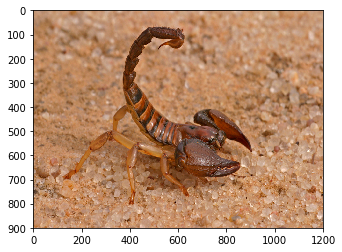

In [17]:
%matplotlib inline

image_path = 'test_image_scorpion.jpg'
image = Image.open(image_path)
img_tensor = preprocess(image)
img_tensor.unsqueeze_(0)

normalizer_module = NormalizeIt()

logits = model.forward(normalizer_module .forward(Variable(torch.FloatTensor(img_tensor)))).data.numpy()
my_label_str = labels.get_label(np.argmax(logits, axis=1)[0])
imshow(np.asarray(image))
print("The class is ", my_label_str)

<IPython.core.display.Javascript object>


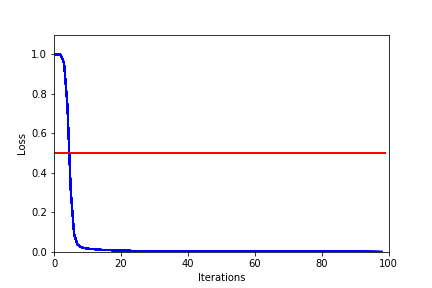

Converted to loss 0.003439188003540039 in iterations 100
Changed class is  crane


<IPython.core.display.Javascript object>


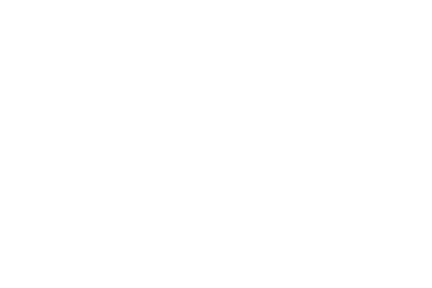

In [25]:
%matplotlib notebook

# Pick second most likely class to fool with
index_required = 134#np.argsort(logits)[0][900]
the_variable = Variable(torch.FloatTensor(img_tensor))
# The loss function
criterion = FoolLoss(index_required)
just_identity = FoolingNoise()
a = list(just_identity.parameters())[0].clone()

fig,ax = plt.subplots(1,1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_xlim(0,100)
ax.set_ylim(0,1.1)


def plot_loss(ax, array):
    ax.plot(array,'b')
    ax.plot(np.arange(100), np.ones(100)*0.5,'r')
    fig.canvas.draw()

optimizer = torch.optim.Adam(just_identity.parameters(), lr=0.01)
num_iteration = loss_value = 1
loss_array=[]
while loss_value > 0.0001 and num_iteration < 100:
    loss=criterion(model.forward(normalizer_module.forward(just_identity.forward(the_variable))))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_value = loss.data[0]
#    print("Loss", loss_value)
    num_iteration += 1
    loss_array.append(loss_value)
    plot_loss(ax, loss_array)

if loss_value > 0.5:
    print("Failed to converge")
else:
    print("Converted to loss", loss_value, "in iterations", num_iteration)

required_image = just_identity.noise.data + the_variable.data
logits = model.forward(normalizer_module.forward(just_identity.forward(the_variable))).data.numpy()
my_label_str = labels.get_label(np.argmax(logits, axis=1)[0])

print("Changed class is ", my_label_str)

mean_r = 0.485
mean_g = 0.456
mean_b = 0.406

std_r = 0.229
std_g = 0.456
std_b = 0.225


back_transform = transforms.Compose([
   transforms.ToPILImage()
])


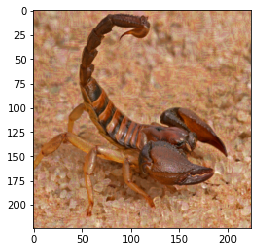

In [26]:
%matplotlib inline

required_image = just_identity.noise.float().data + the_variable.data
required_image[:,0] = required_image[:,0] * std_r + mean_r
required_image[:,1] = required_image[:,1] * std_g + mean_g
required_image[:,2] = required_image[:,2] * std_b + mean_b
img = reshape_back(required_image.numpy())
image = back_transform(required_image[0])
imshow(np.asarray(image))
